In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

In [3]:
data_path = Path('../data/whale/')

In [4]:
data_path.ls()

[PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/sample_submission.csv'),
 PosixPath('../data/whale/test_csv_2.csv'),
 PosixPath('../data/whale/train_csv_2.csv'),
 PosixPath('../data/whale/models'),
 PosixPath('../data/whale/test')]

In [5]:
train_csv2 = pd.read_csv(data_path/'train_csv_2.csv')
test_csv2 = pd.read_csv(data_path/'test_csv_2.csv')

In [6]:
train_csv2.head(2)

Image         Id           sizes      keras_model_bbox
0  0000e88ab.jpg  w_f48451c  [3, 700, 1050]  (233, 160, 852, 417)
1  0001f9222.jpg  w_c3d896a   [3, 325, 758]     (0, 79, 744, 239)

### bbox check and preprocess

In [7]:
train_csv2.keras_model_bbox = train_csv2.keras_model_bbox.apply(lambda x: eval(x))
test_csv2.keras_model_bbox = test_csv2.keras_model_bbox.apply(lambda x: eval(x))

In [8]:
train_csv2.sizes = train_csv2.sizes.apply(lambda x: eval(x))
test_csv2.sizes = test_csv2.sizes.apply(lambda x: eval(x))

In [9]:
# check bboxes and clip if necessary
def check_bboxes(df):
    """
    Validate the bboxes by matching with image size
    """
    bad_idxs = []
    for idx, (szs, bbxes) in df[['sizes', 'keras_model_bbox']].iterrows():

        _,y,x = szs 
        x1,y1,x2,y2 = bbxes

        x1 = np.clip(x1,a_min=0, a_max=x)
        y1 = np.clip(y1,a_min=0, a_max=y)
        x2 = np.clip(x2,a_min=0, a_max=x)
        y2 = np.clip(y2,a_min=0, a_max=y)

        x1, y1, x2, y2

        if not x2 - x1 > 0: 
            bad_idxs.append(idx)
            continue
        if not y2 - y1 > 0:
            bad_idxs.append(idx)
            continue
    return bad_idxs

In [10]:
train_bad_idxs = check_bboxes(train_csv2)
test_bad_idxs = check_bboxes(test_csv2)

In [11]:
train_csv2.iloc[train_bad_idxs]

Empty DataFrame
Columns: [Image, Id, sizes, keras_model_bbox]
Index: []

In [12]:
test_csv2.iloc[test_bad_idxs]

Empty DataFrame
Columns: [Image, sizes, keras_model_bbox]
Index: []

In [13]:
# make their bbox the whole image
train_csv2.loc[train_bad_idxs, 'keras_model_bbox'] = \
train_csv2.loc[train_bad_idxs, 'sizes'].apply(lambda x: [0,0,x[2],x[1]]).values

In [14]:
test_csv2.loc[test_bad_idxs, 'keras_model_bbox'] = \
test_csv2.loc[test_bad_idxs, 'sizes'].apply(lambda x: [0,0,x[2],x[1]]).values

In [45]:
# train_csv2.to_csv(data_path/'train_csv_2.csv', index=False)
# test_csv2.to_csv(data_path/'test_csv_2.csv', index=False)

### All new whales

Find number new whales in public test set

In [8]:
test_csv2.shape

(7960, 3)

In [14]:
sample_submission = pd.read_csv(data_path/'sample_submission.csv'); sample_submission.head(2)

Image                                                 Id
0  00028a005.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
1  000dcf7d8.jpg  new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c

In [9]:
!kaggle competitions submit -c humpback-whale-identification -f '../data/whale/sample_submission.csv' -m "{all-whales-submission}"

100%|█████████████████████████████████████████| 498k/498k [00:01<00:00, 255kB/s]
Successfully submitted to Humpback Whale Identification

In [20]:
!kaggle competitions submissions -c humpback-whale-identification

fileName                     date                 description              status    publicScore  privateScore  
---------------------------  -------------------  -----------------------  --------  -----------  ------------  
sample_submission.csv        2018-12-20 06:10:12  {all-whales-submission}  complete  0.277        None          
mpiotte-standard-235.csv.gz  2018-12-18 20:43:05  {mpiotte-standard-235}   complete  0.585        None          
mpiotte-standard-120.csv.gz  2018-12-18 20:01:53  {mpiotte-standard-120}   complete  0.349        None          
mpiotte-standard-10.csv.gz   2018-12-18 06:45:14  {mpiotte-standard-10}    complete  0.113        None          


In [21]:
public_leaderboard_new_whale_ratio = 0.227

In [27]:
training_new_whale_ratio = np.round(sum(train_csv2['Id'] == 'new_whale') / len(train_csv2), 3)

In [34]:
print(f"public_leaderboard_new_whale_ratio: {public_leaderboard_new_whale_ratio}")
print(f"training_new_whale_ratio: {training_new_whale_ratio}")
print(f"public leaderboard num new whales: {int(public_leaderboard_new_whale_ratio*len(test_csv2))}")
print(f"training num new whales: {int(training_new_whale_ratio*len(train_csv2))}")

public_leaderboard_new_whale_ratio: 0.227
training_new_whale_ratio: 0.381
public leaderboard num new whales: 1806
training num new whales: 9662


### Data

**Keys**

w : whale label

In [15]:
train_csv2.head(3)

Image         Id           sizes      keras_model_bbox
0  0000e88ab.jpg  w_f48451c  [3, 700, 1050]  (233, 160, 852, 417)
1  0001f9222.jpg  w_c3d896a   [3, 325, 758]     (0, 79, 744, 239)
2  00029d126.jpg  w_20df2c5  [3, 497, 1050]   (25, 20, 1012, 462)

In [16]:
# whale id image counts - number of whale ids with only single image
w_counts = train_csv2.groupby(['Id'])['Id'].count().sort_values(ascending=False)
print(f"number of whale ids with single image: {sum(w_counts == 1)}")
print(f"number of unique whale ids in training: {len(w_counts)}")

number of whale ids with single image: 2073
number of unique whale ids in training: 5005


In [17]:
w2counts = dict(w_counts)
counts2w = {w2counts[k]:k for k in w2counts}

In [18]:
w2fnames = dict(train_csv2.groupby(['Id'])['Image'].apply(lambda x: list(x)))

In [19]:
list(w2fnames.items())[-5:]

[('w_ff94900', ['5ac086036.jpg']),
 ('w_ffa542b', ['4f9e431aa.jpg', '8abea550e.jpg', 'cd3a073a2.jpg']),
 ('w_ffa6d42', ['9dd320bb3.jpg']),
 ('w_ffcf5fe', ['d3967e1df.jpg']),
 ('w_ffe8693', ['df4bbd82a.jpg'])]

### ImageBBox

In [20]:
from fastai.vision.transform import *
import pdb

In [21]:
# convert bbox coords to have y first
def bb_xf2yf(bb):
    new_bb = [bb[:2][::-1] + bb[2:][::-1]]
    return new_bb
    
train_csv2['bboxes'] = train_csv2.keras_model_bbox.apply(lambda x: bb_xf2yf(x))
test_csv2['bboxes'] = test_csv2.keras_model_bbox.apply(lambda x: bb_xf2yf(x))

In [22]:
def get_bb_ex(i=0):
    img = open_image(data_path/'train'/train_csv2['Image'][i])
    bb = train_csv2['bboxes'][i]
    bbox = ImageBBox.create(*img.size, bboxes=bb)
    return img, bbox

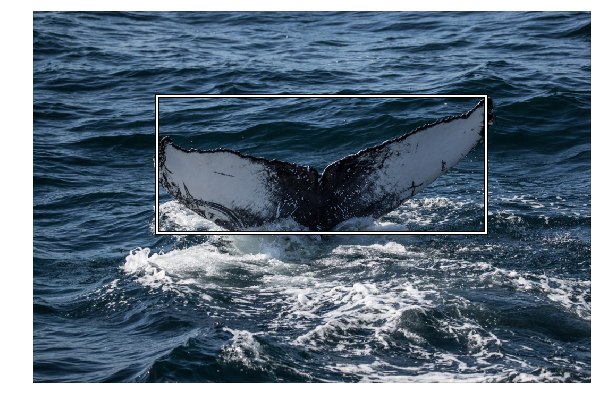

In [17]:
img, bbox = get_bb_ex(); img.show(y=bbox, figsize=(10,10))

In [23]:
def crop_img_with_bbox(img, bbox):
    bb = bbox.data[0]
    h,w = bbox.flow.size
    bb_np = (to_np(bb + 1)*([h/2, w/2, h/2, w/2])).astype(int)
    return Image(img.data[:, bb_np[0]:bb_np[2], bb_np[1]:bb_np[3]])

In [24]:
def resize_pad(img, size=224):
    """Resize to square keeping aspect ratio same"""
    new_sz = resize_to(img, size)
    img._flow = None
    img = img.resize((img.shape[0],*new_sz))
    
    lr, up = size - new_sz[0], size - new_sz[1]
    lr_div, lr_mod = divmod(lr, 2)
    up_div, up_mod = divmod(up, 2)
    return Image(F.pad(img.data, (up_div, up_div + up_mod, lr_div, lr_div + lr_mod)))

torch.Size([3, 700, 1050])


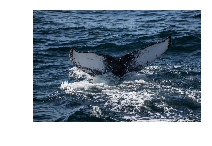

In [27]:
print(img.shape); img.show()

torch.Size([3, 257, 619])


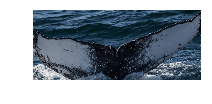

In [25]:
cropped_img = crop_img_with_bbox(img, bbox)
print(cropped_img.shape); cropped_img.show()

torch.Size([3, 224, 224])


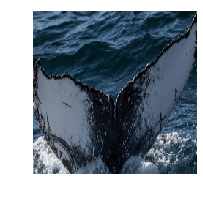

In [36]:
cropped_resized_img = crop_img_with_bbox(img, bbox).resize(224)
print(cropped_resized_img.px.shape); cropped_resized_img.show()

torch.Size([3, 224, 224])


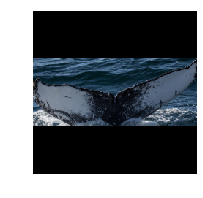

In [37]:
cropped_pad_resized_img = resize_pad(crop_img_with_bbox(img, bbox), size=224)
print(cropped_pad_resized_img.px.shape); cropped_pad_resized_img.show()

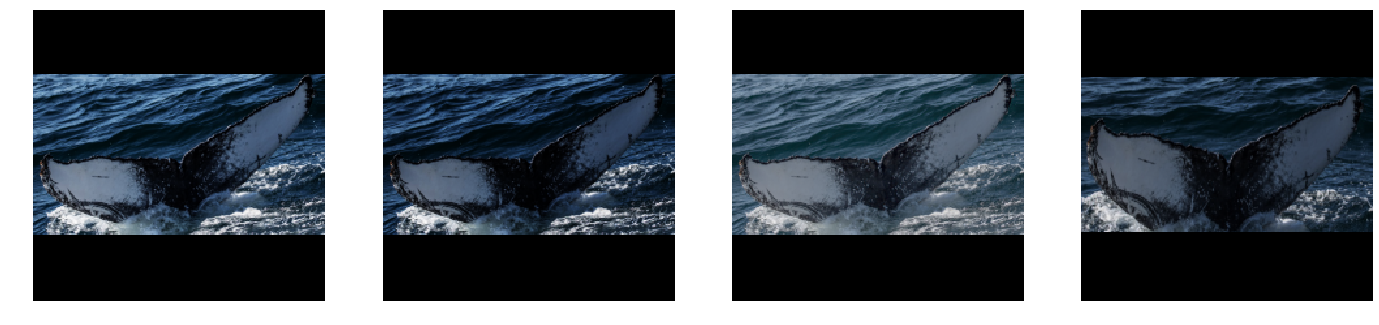

In [38]:
# transforms
tfms = [[], []]
tfms[0].append(flip_affine(p=0.5))
max_lighting = 0.3; p_lighting=0.5
tfms[0].append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
tfms[0].append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
tfms[0].append(rotate(degrees=10, p=0.5))
max_warp = 0.3
tfms[0].append(symmetric_warp(magnitude=(-max_warp,max_warp), p=0.3))

_, axs = plt.subplots(1,4,figsize=(24,12))
for ax in axs.flatten():
    img, bbox = get_bb_ex()
    img = img.apply_tfms(tfms[0])
    bbox = bbox.apply_tfms(tfms[0], do_resolve=False)
    img = crop_img_with_bbox(img, bbox)
    img = resize_pad(img, size=224)
    img.show(ax=ax)

### dataset

In [25]:
# transforms
tfms = [[], []]
tfms[0].append(flip_affine(p=0.5))
max_lighting = 0.3; p_lighting=0.5
tfms[0].append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
tfms[0].append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
tfms[0].append(rotate(degrees=10, p=0.5))
max_warp = 0.3
tfms[0].append(symmetric_warp(magnitude=(-max_warp,max_warp), p=0.3))

In [26]:
tfms

[[RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.4285714285714286)}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': 10}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.3, 0.3)}, p=0.3, resolved={}, do_run=True, is_random=True)],
 []]

In [27]:
idx2w = dict(enumerate(w2counts.keys()))
w2idx = {idx2w[k]:k for k in idx2w}

In [98]:
def create_func(item, path=data_path/'train', do_transform=True, keep_aspect_ratio=True, size=224):
    img = open_image(path/item[0])
    bb = item[2]
    bbox = ImageBBox.create(*img.size, bboxes=bb)
    TFMS = tfms[0] if do_transform else tfms[1]
    img = img.apply_tfms(TFMS)
    bbox = bbox.apply_tfms(TFMS, do_resolve=False)
    try: bbox.data[0]
    except: print(bbox.data, item)
    img = crop_img_with_bbox(img, bbox)
    if keep_aspect_ratio:
        img = resize_pad(img, size=size)
    else:
        img._flow = None
        img.resize(224)        
    return img, Category(w2idx[item[1]], item[1])

In [99]:
class WhaleDataset(object):
    def __init__(self, df, path=data_path/'train', **kwargs):
        self.items = df[['Image', 'Id', 'bboxes']].values  
        self.path = path
        self.kwargs = kwargs
        
    def __getitem__(self, i):
        item = self.items[i]
        return create_func(item, **self.kwargs)
        
    def __len__(self):
        return len(self.items)

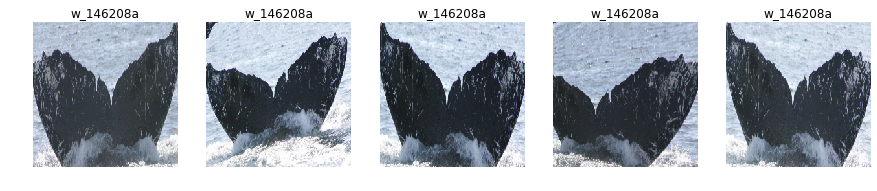

In [46]:
# dont' keep aspect ratio
train_ds = WhaleDataset(df = train_csv2, path=data_path/'train', keep_aspect_ratio=False)
_,axs = plt.subplots(1,5,figsize=(15,5))
for i,ax in enumerate(axs): train_ds[1000][0].show(ax=ax, title=f'{train_ds[1000][1]}')

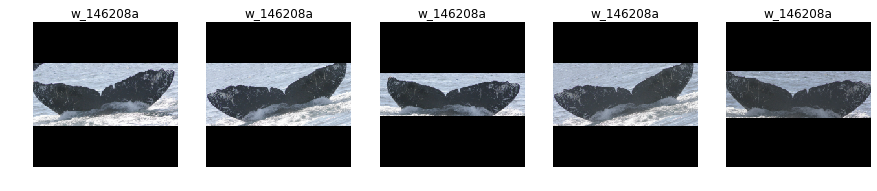

In [47]:
# keep aspect ratio
train_ds = WhaleDataset(df = train_csv2, path=data_path/'train', keep_aspect_ratio=True)
_,axs = plt.subplots(1,5,figsize=(15,5))
for i,ax in enumerate(axs): train_ds[1000][0].show(ax=ax, title=f'{train_ds[1000][1]}')

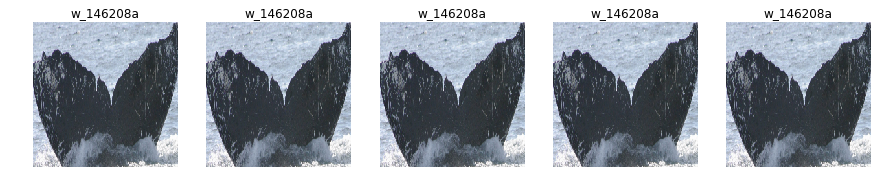

In [48]:
# dont' keep aspect ratio and valid
train_ds = WhaleDataset(df = train_csv2, path=data_path/'train', keep_aspect_ratio=False, do_transform=False)
_,axs = plt.subplots(1,5,figsize=(15,5))
for i,ax in enumerate(axs): train_ds[1000][0].show(ax=ax, title=f'{train_ds[1000][1]}')

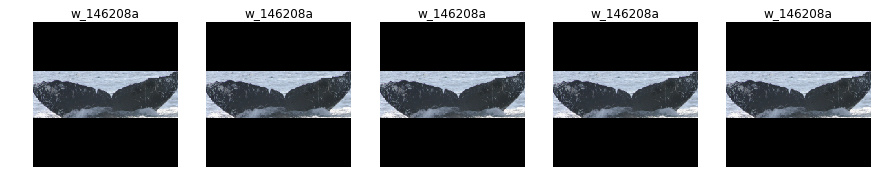

In [49]:
# keep aspect ratio and if valid
train_ds = WhaleDataset(df = train_csv2, path=data_path/'train', keep_aspect_ratio=True, do_transform=False)
_,axs = plt.subplots(1,5,figsize=(15,5))
for i,ax in enumerate(axs): train_ds[1000][0].show(ax=ax, title=f'{train_ds[1000][1]}')

### save cropped images 

- Both aspect ratio fixed and not

In [79]:
items = train_csv2[['Image', 'Id', 'bboxes']].values

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 35.8 ms


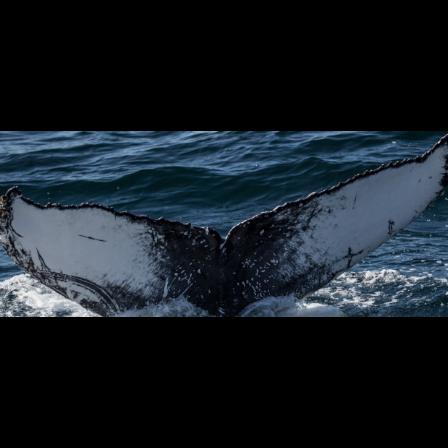

In [86]:
%%time
create_func(items[0], do_transform=False, keep_aspect_ratio=True, size=448)[0]

CPU times: user 512 ms, sys: 20 ms, total: 532 ms
Wall time: 159 ms


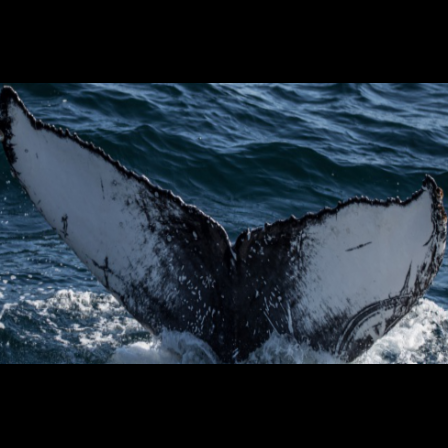

In [94]:
%%time
create_func(items[0], do_transform=True, keep_aspect_ratio=True, size=448)[0]

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 30.9 ms


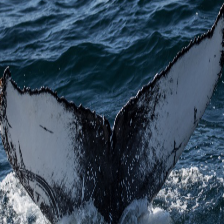

In [98]:
%%time
create_func(items[0], do_transform=False, keep_aspect_ratio=False, size=448)[0]

CPU times: user 416 ms, sys: 16 ms, total: 432 ms
Wall time: 135 ms


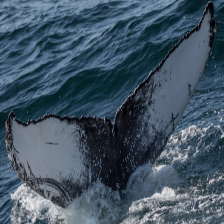

In [99]:
%%time
create_func(items[0], do_transform=True, keep_aspect_ratio=False, size=448)[0]

### Crop + TFMS - (speed up saving cropped images)

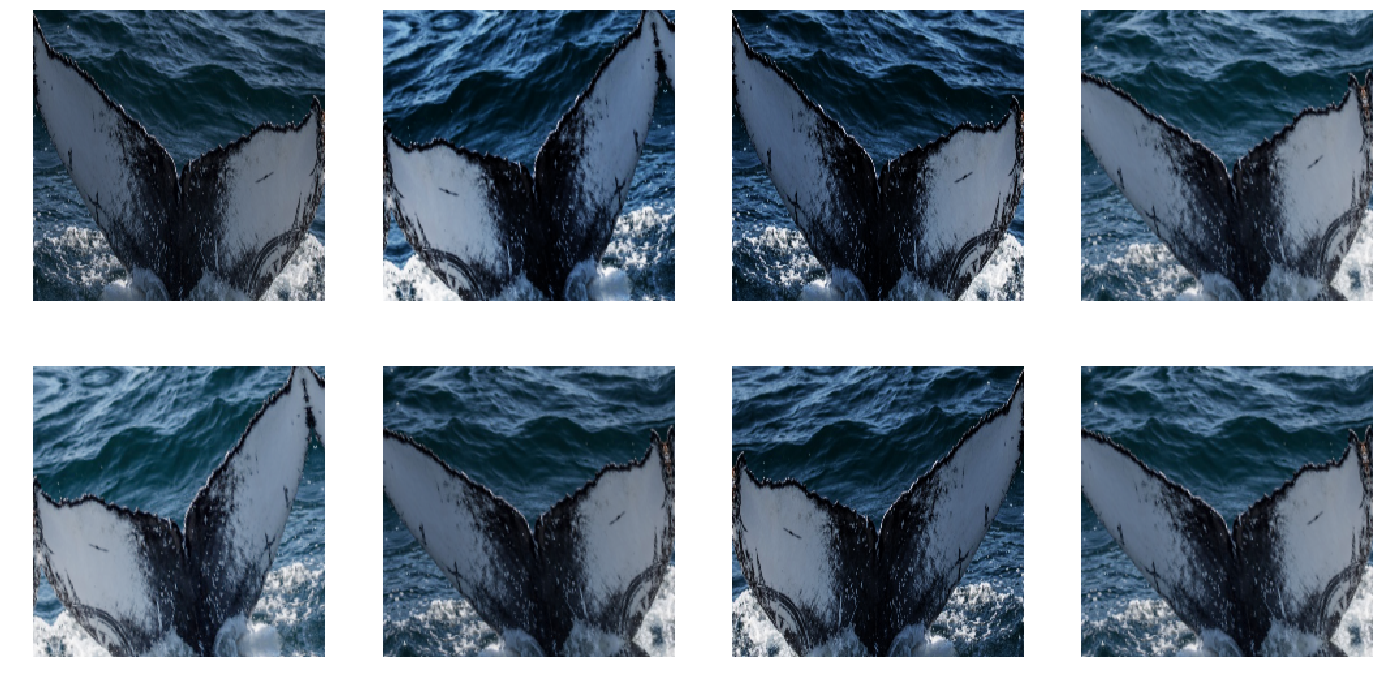

In [72]:
# transforms
tfms = [[], []]
tfms[0].append(flip_affine(p=0.5))
max_lighting = 0.3; p_lighting=0.5
tfms[0].append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
tfms[0].append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
tfms[0].append(rotate(degrees=10, p=0.5))
max_warp = 0.3
tfms[0].append(symmetric_warp(magnitude=(-max_warp,max_warp), p=0.3))

_, axs = plt.subplots(2,4,figsize=(24,12))
for ax in axs.flatten():
    img, bbox = get_bb_ex()
    img = crop_img_with_bbox(img, bbox)
#     img = resize_pad(img, size=224)
    img.resize(224)
    img = img.apply_tfms(tfms[0])
    img.show(ax=ax)

### databunch 

In [31]:
from ipyexperiments import *

In [32]:
# no bboxes missing
assert sum(train_csv2['bboxes'].apply(lambda x: len(x[0])) != 4) == 0
assert sum(test_csv2['bboxes'].apply(lambda x: len(x[0])) != 4) == 0

In [33]:
# if only has 1 image put to train else split trn-val as max(2, len(x)*0.1)
np.random.seed(42)
train_fnames = []
valid_fnames = []
val_ratio = 0.2
for _, fnames in w2fnames.items():
    if len(fnames) == 1:
        train_fnames += fnames
    else:
        n = len(fnames)
        n_val = max(2, int(n*val_ratio)) 
        fnames = np.random.permutation(fnames)
        train_fnames += list(fnames[n_val:])
        valid_fnames += list(fnames[:n_val])

In [34]:
len(train_fnames), len(valid_fnames)

(17232, 8129)

## Experiments

### plain training

In [35]:
train_df = train_csv2[train_csv2.Image.isin(train_fnames)]
train_ds = WhaleDataset(df = train_df, path=data_path/'train', keep_aspect_ratio=True, do_transform=False)

In [36]:
valid_df = train_csv2[train_csv2.Image.isin(valid_fnames)]
valid_ds = WhaleDataset(df = valid_df, path=data_path/'train', keep_aspect_ratio=True, do_transform=False)

In [37]:
train_ds[0], valid_ds[0]

((Image (3, 224, 224), Category w_f48451c),
 (Image (3, 224, 224), Category new_whale))

In [38]:
data = ImageDataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=64, num_workers=4)
data.c = len(w2idx)

In [39]:
len(data.train_ds), len(data.valid_ds)

(17232, 8129)

In [40]:
learner = create_cnn(data=data, arch=models.resnet18, metrics=[accuracy], loss_func=nn.CrossEntropyLoss())

In [41]:
learner.fit_one_cycle(1)

### upsampled training no augmentation - random batch

In [53]:
sample_to = 20
grouped = train_df.groupby('Id')
upsample_train_df = grouped.apply(lambda x: x if len(x) > sample_to else x.sample(sample_to, replace=True))

In [86]:
len(train_df), len(valid_df)

(17232, 8129)

In [57]:
upsample_train_df = upsample_train_df.reset_index(drop=True)

In [100]:
upsampled_train_ds = WhaleDataset(df = upsample_train_df, path=data_path/'train',  do_transform=False,
                                  keep_aspect_ratio=True)

In [101]:
upsampled_train_ds[0]

(Image (3, 224, 224), Category new_whale)

In [102]:
data = ImageDataBunch.create(train_ds=upsampled_train_ds, valid_ds=valid_ds, bs=64, num_workers=4)
data.c = len(w2idx)

In [103]:
learner = create_cnn(data=data, arch=models.resnet18, metrics=[accuracy], loss_func=nn.CrossEntropyLoss())

In [104]:
learner.fit_one_cycle(1, max_lr=slice(2e-2))

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f2af99d1730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f2af99d1730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/h

### upsampled training with augmentation - random batch

In [107]:
upw2counts = upsample_train_df['Id'].value_counts()

In [108]:
upsampled_train_ds = WhaleDataset(df = upsample_train_df, path=data_path/'train',
                                  keep_aspect_ratio=True, do_transform=True)

In [109]:
data = ImageDataBunch.create(train_ds=upsampled_train_ds, valid_ds=valid_ds, bs=64, num_workers=4)
data.c = len(w2idx)

In [110]:
learner = create_cnn(data=data, arch=models.resnet18, metrics=[accuracy], loss_func=nn.CrossEntropyLoss())

In [112]:
learner.fit_one_cycle(2, max_lr=2e-2)

KeyboardInterrupt: 

### upsampled training with augmentation - uniform batch

### upsampled training with augmentation - without new whales + treshold for new whales